In [60]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics import accuracy_score, roc_curve, auc
from tqdm import tqdm

# Инфра

In [61]:
class LabeledImage:
    def __init__(self, image_path, image_label):
        self.path = image_path
        self.label = image_label


def parse_dataset(dataset_dir) -> list[LabeledImage]:
    """
    Парсит датасет со структурой ./dir/<person>/<image>.jpg
    """
    labeled_images = []
    dir_path = f"./{dataset_dir}"
    for person in os.listdir(dir_path):
        person_dir = os.path.join(dir_path, person)
        if os.path.isdir(person_dir):
            for img in os.listdir(person_dir):
                if img.lower().endswith(('.jpg', 'png', 'jpeg')):
                    path = os.path.join(person_dir, img)
                    labeled_images.append(LabeledImage(path, person))
    return labeled_images


embedding_cache = {}

def get_embedding(img_path, model, show=False):
    if img_path in embedding_cache:
        return embedding_cache[img_path]

    img = Image.open(img_path).convert('RGB')
    face = mtcnn(img)

    if face is None:
        print(f"Лицо не обнаружено. path = {img_path}")
        return None

    if show:
        face_np = face.permute(1, 2, 0).cpu().numpy()
        face_np = np.clip(face_np, 0, 1)

        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img)
        axs[0].set_title("Оригинал")
        axs[0].axis('off')

        axs[1].imshow(face_np)
        axs[1].set_title("Обработанное лицо")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

    with torch.no_grad():
        embedding = model(face.unsqueeze(0).to(device))
    embedding_np = embedding.cpu().numpy()[0]
    embedding_cache[img_path] = embedding_np
    return embedding_np


def get_emb_distance(emb1, emb2):
    return np.linalg.norm(emb1 - emb2)


def get_img_distance(img1_path, img2_path, model):
    emb1 = get_embedding(img1_path, model)
    emb2 = get_embedding(img2_path, model)
    return get_emb_distance(emb1, emb2)


def verify_face(face1_path, face2_path, model, threshold=1.0) -> bool:
    dist = get_img_distance(face1_path, face2_path, model)
    print(f"Distance: {dist:.4f}")
    if dist < threshold:
        return True
    else:
        return False

# FaceNet

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используем {device}")
mtcnn = MTCNN(image_size=160, margin=0, device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Используем cpu


In [74]:
def load_lfw_test():
    lfw_dir = 'dataset/lfw_funneled'
    pairs_file = 'dataset/pairsDevTest.txt'

    with open(pairs_file, 'r') as f:
        lines = f.readlines()[1:]

    pairs = []
    labels = []

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            # positive pair: name, idx1, idx2
            name, idx1, idx2 = parts
            img1 = os.path.join(lfw_dir, name, f"{name}_{int(idx1):04d}.jpg")
            img2 = os.path.join(lfw_dir, name, f"{name}_{int(idx2):04d}.jpg")
            label = 1
        elif len(parts) == 4:
            # negative pair: name1, idx1, name2, idx2
            name1, idx1, name2, idx2 = parts
            img1 = os.path.join(lfw_dir, name1, f"{name1}_{int(idx1):04d}.jpg")
            img2 = os.path.join(lfw_dir, name2, f"{name2}_{int(idx2):04d}.jpg")
            label = 0
        else:
            print(f"Invalid line: {parts}")
            break

        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(label)
        else:
            print(f"Invalid line: {parts}")
            break

    pair_labels = [(pairs[i], labels[i]) for i in range(len(pairs))]
    print(f"Загружено {len(pairs)} пар")
    return pair_labels

def test_model(pair_labels, model):
    distances_list, y_true = [], []
    for (img1, img2), label in tqdm(pair_labels, total=len(pair_labels)):
        e1 = get_embedding(img1, model)
        e2 = get_embedding(img2, model)

        if e1 is None or e2 is None:
            continue

        dist = get_emb_distance(e1, e2)
        distances_list.append(dist)
        y_true.append(label)

    distances = np.vstack(distances_list)
    y_true = np.array(y_true)

    fpr, tpr, thresholds = roc_curve(y_true, -distances)
    roc_auc = auc(fpr, tpr)

    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)
    best_thresh = thresholds[ix]

    y_pred = (distances < -best_thresh).astype(int)
    acc = accuracy_score(y_true, y_pred)

    print(f"AUC = {roc_auc:.4f}")
    print(f"Optimal threshold = {-best_thresh :.4f}")
    print(f"Accuracy = {acc:.4f}")

pair_labels = load_lfw_test()
test_model(pair_labels, facenet)

Загружено 1000 пар


100%|██████████| 1000/1000 [00:00<00:00, 165717.27it/s]

AUC = 0.9751
Optimal threshold = 1.0212
Accuracy = 0.9650


# Тестирование

In [93]:
import os
import itertools
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

labeled_images = parse_dataset("test")

embeddings = list()
labels = list()

for labeled_image in tqdm(labeled_images, total=len(labeled_images)):
    embeddings.append(get_embedding(labeled_image.path, facenet))
    labels.append(labeled_image.label)

embeddings = np.stack(embeddings)
labels = np.array(labels)

N = len(labeled_images)
D = np.zeros((N, N))
for i, j in itertools.product(range(N), range(N)):
    D[i, j] = get_emb_distance(embeddings[i], embeddings[j])

threshold = 0.97

pairs = list(itertools.combinations(range(N), 2))
print(f"Пар изображений: {len(pairs)}")

y_true, y_pred = [], []

print(f"Результаты сравнений: (threshold={threshold})")
for i, j in pairs:
    dist = D[i, j]
    match = dist < threshold
    is_the_same_person = labels[i] == labels[j]
    
    y_true.append(is_the_same_person)
    y_pred.append(match)

    is_correct = match == is_the_same_person
    print(f"{os.path.basename(labeled_images[i].path)} - {os.path.basename(labeled_images[j].path)}: "
          f"\t\tdist={dist:.2f}\t"
          f"\tОдин человек: {'✔️' if match else '✖️'}"
          f"  /  {'✅' if is_correct else '❌'}")

100%|██████████| 15/15 [00:00<00:00, 14972.53it/s]

Пар изображений: 105
Результаты сравнений: (threshold=0.97)
Egor_Alexeev_1.png - Egor_Alexeev_2.jpg: 		dist=0.99		Один человек: ✖️  /  ❌
Egor_Alexeev_1.png - Egor_Alexeev_3.jpg: 		dist=0.72		Один человек: ✔️  /  ✅
Egor_Alexeev_1.png - Egor_Alexeev_4.jpg: 		dist=0.92		Один человек: ✔️  /  ✅
Egor_Alexeev_1.png - Egor_Alexeev_5.jpg: 		dist=0.70		Один человек: ✔️  /  ✅
Egor_Alexeev_1.png - Misha_Gavrilyak_1.jpg: 		dist=1.28		Один человек: ✖️  /  ✅
Egor_Alexeev_1.png - Misha_Gavrilyak_2.jpg: 		dist=1.11		Один человек: ✖️  /  ✅
Egor_Alexeev_1.png - Misha_Gavrilyak_3.jpg: 		dist=1.21		Один человек: ✖️  /  ✅
Egor_Alexeev_1.png - Misha_Gavrilyak_4.jpg: 		dist=1.10		Один человек: ✖️  /  ✅
Egor_Alexeev_1.png - Misha_Gavrilyak_5.jpg: 		dist=1.19		Один человек: ✖️  /  ✅
Egor_Alexeev_1.png - Misha_Gavrilyak_6.jpg: 		dist=1.21		Один человек: ✖️  /  ✅
Egor_Alexeev_1.png - Misha_Gavrilyak_7.jpg: 		dist=1.05		Один человек: ✖️  /  ✅
Egor_Alexeev_1.png - Misha_Melnikov_1.jpg: 		dist=1.31		Один человек: ✖️

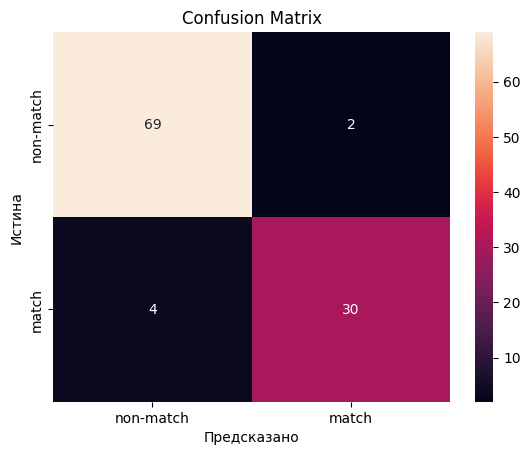

              precision    recall  f1-score   support

   non-match       0.95      0.97      0.96        71
       match       0.94      0.88      0.91        34

    accuracy                           0.94       105
   macro avg       0.94      0.93      0.93       105
weighted avg       0.94      0.94      0.94       105



In [94]:
cm = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['non-match', 'match'],
            yticklabels=['non-match', 'match'])
plt.xlabel('Предсказано')
plt.ylabel('Истина')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=['non-match', 'match']))

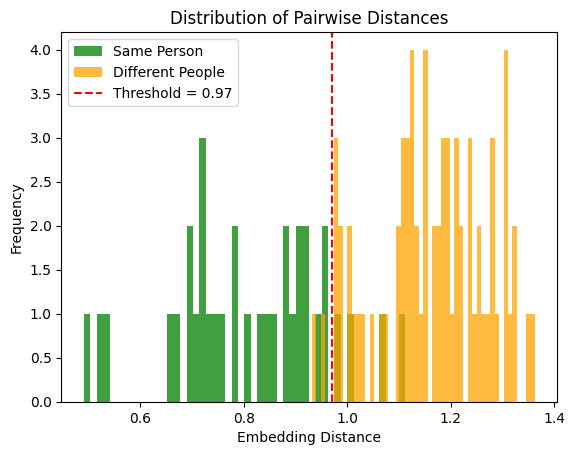

In [95]:
same_dists = [D[i, j] for i, j in pairs if labels[i] == labels[j]]
diff_dists = [D[i, j] for i, j in pairs if labels[i] != labels[j]]

plt.hist(same_dists, bins=50, alpha=0.75, label="Same Person", color="green")
plt.hist(diff_dists, bins=50, alpha=0.75, label="Different People", color="orange")
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel("Embedding Distance")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Pairwise Distances")
plt.show()

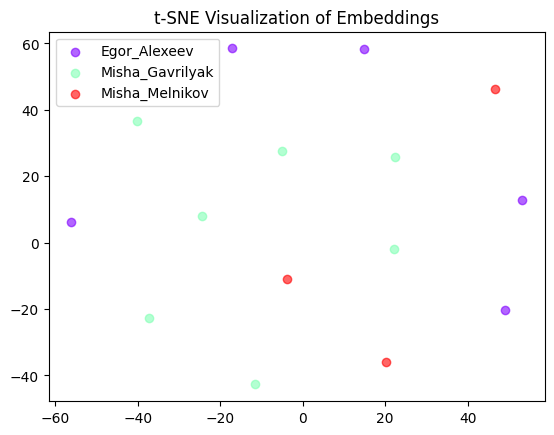

In [96]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

n_samples = embeddings.shape[0]
perplexity = min(30, n_samples - 1)

tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
reduced = tsne.fit_transform(embeddings)

unique_labels = np.unique(labels)
colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_to_color = {str(lbl): color for lbl, color in zip(unique_labels, colors)}

for label in unique_labels:
    label_str = str(label)
    idxs = labels == label
    plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=label_str, color=label_to_color[label_str], alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization of Embeddings")
plt.show()


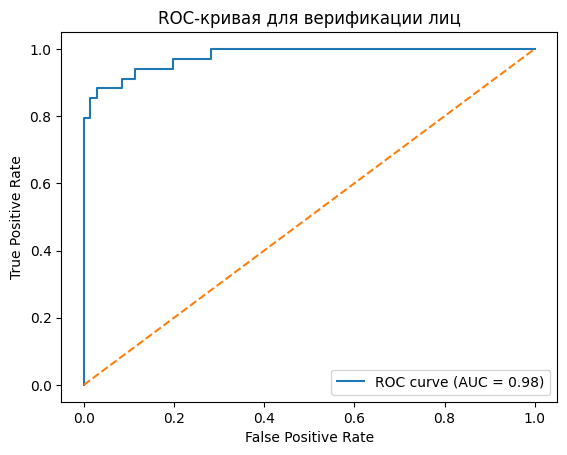

In [97]:
from sklearn.metrics import roc_curve, auc
# Подготовка данных
y_true = [labels[i] == labels[j] for i, j in pairs]
y_scores = [-D[i, j] for i, j in pairs]  # чем меньше расстояние, тем выше вероятность совпадения
# Вычисление ROC
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
# Построение графика
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для верификации лиц')
plt.legend()
plt.show()